# 18460 Project

In [1]:
from client import *
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from problem import *
from server import *

First, we load the dataset and partition it

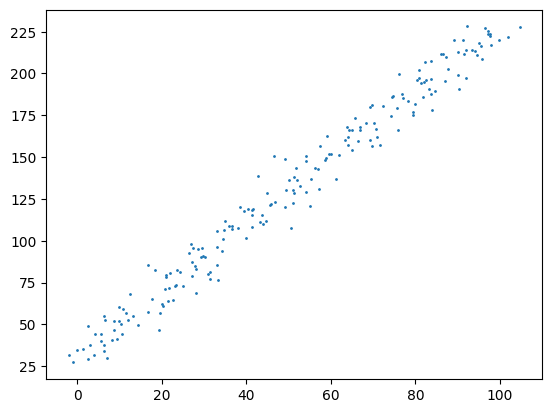

In [2]:
# TODO: load (and format) and partition dataset

# Example: Linear regression
x = np.linspace(0, 100, num=200)
y = 2*x + 30

points = np.stack((x, y), axis=-1)

dataset = points + 4*np.random.standard_normal(points.shape) # add noise to points

plt.scatter(dataset[:, 0], dataset[:, 1], s=1)

partitions = dataset.reshape((10, 20, 2)) # 10 clients with 20 points each

Then, we define our optimization problem

In [3]:
# TODO: define cost functions and optimization hyperparameters

hyper_parameters = {
    "penalty": 10,
    "x0": np.random.standard_normal((2, 1)) # one multiplicative term and one bias term
}

# simple linear regression cost (mean squarred error loss)
def cost(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points
    
    prediction = m*preimages + b
    
    return np.sum((prediction - images)**2) / len(dataset)

def cost_grad(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points
    
    prediction = m*preimages + b
    
    grad = np.array([
        np.sum(2*preimages*(prediction - images)),
        np.sum(2*(prediction - images))
    ]) / len(dataset)
    
    return grad[:, None] # make sure to return something with shape (2, 1)

def cost_hessian(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points

    hessian = np.array([
        [np.sum(2*(preimages**2)), np.sum(2*preimages)],
        [np.sum(2*preimages),           2*len(dataset)]
    ]) / len(dataset)
    
    return hessian

problem = OptimizationProblem(tol=1e-4, ctol=1e-6, max_iter=100000, lr=0.0001, loss=cost, loss_grad=cost_grad, 
                              loss_hessian=cost_hessian, hyper_parameters=hyper_parameters)

Solve iteratively using federated learning

In [4]:
# TODO: create server and initialize clients, before iteratively updating the consensus variables
server = Server(problem)
server.connect_clients(partitions) # add parameters and communicate datasets

k = 0
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = cost(consensus, dataset, problem.hyper_parameters)
    
    if k % 5000 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost
    
    k = k + 1
    
if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")
    
solution = server.consensus.flatten()
    
print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")


        Iteration 0: [ 0.77370931 -1.36572061]
        Cost: 9872.663907966384

        

        Iteration 5000: [2.86509991 1.2876152 ]
        Cost: 990.9871482992822

        

        Iteration 10000: [2.78615958 3.69628064]
        Cost: 831.7041949845678

        

        Iteration 15000: [2.71147695 5.97800881]
        Cost: 695.2808484570563

        

        Iteration 20000: [2.64073953 8.13906292]
        Cost: 578.775949318731

        

        Iteration 25000: [ 2.57375603 10.18535921]
        Cost: 479.85548343772314

        

        Iteration 30000: [ 2.5103445 12.1225367]
        Cost: 396.4312311884369

        

        Iteration 35000: [ 2.45033141 13.95596983]
        Cost: 326.6351842135122

        

        Iteration 40000: [ 2.39355121 15.69078033]
        Cost: 268.7978548386975

        

        Iteration 45000: [ 2.33984605 17.33184859]
        Cost: 221.42863152088822

        

        Iteration 50000: [ 2.28906537 18.88382447]
        Cost: 183.1979

## Visualization of the solution

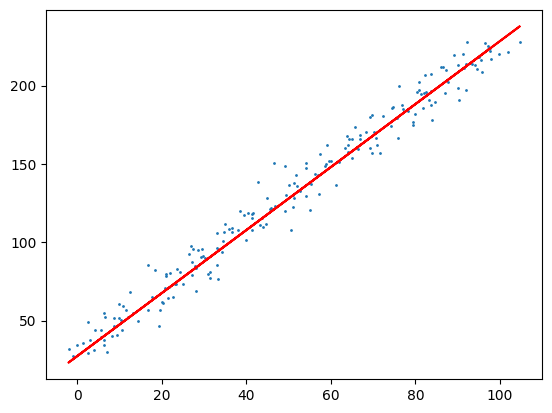

In [6]:
plt.scatter(dataset[:, 0], dataset[:, 1], s=1)
plt.plot(dataset[:, 0], solution[0]*dataset[:, 0] + solution[1], c="red")